# ***Melhoria das redes neurais para a base de cancer de mama***

## Introdução

A ciência de dados lida com vários problemas: previsão de preços, classificação de flores, análises de grupos, etc.

Um dos problemas que a ciência de dados tenta resolver por meio de modelos e estatística é a classificação de tumores que podem ser ou não cânceres de mama. Para tal são usadas diversos dados númericos que correspondem às diversas caracteristicas do tumor (raio, textura, área, concavidade, etc.). Esses dados são subtidos a modelos de classificação binária que determinam qual é mais provavel, ser benigno ou malgno.

Uma forma de criar tais modelos é por meio de uma rede neural. Porém, redes neurais podem possuir diversos tamanhos e parâmetros, qual seria o melhor tamanho e os melhores parâmetros para a melhor rede neural classificadora neste problema?

Esse é o mote deste notebook: determinar, dentre certas opções, quais seriam os melhores parâmetros para a criação desta rede neural.

Serão testados pré processamentos dos dados, otimizadores ('adam', 'SGD', 'RMSprop'), funções de ativação da camada oculta ('relu' e 'elu'), quantidades de neurônios nas camadas ocultas (8, 16, 32), quantidade de camadas ocultas (2, 3, 4) e porcentagens de dropout (0, 0.2, 0.25)

## Atualização das bibliotecas

Foram usadas nesse notebook as bibliotecas Keras, TensorFlow, SciKeras e H5py em suas versões mais atuais. Seção dispensável de execução caso as bibliotecas já estejam atualizadas para a versão mais recente de 2022

In [ ]:
!pip install --upgrade keras

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install scikeras

In [ ]:
!pip install h5py

## Importação das bibliotecas

Aqui são importadas as ferramentas para criação, tunning e validação cruzada da rede neural. Além de bibliotecas essenciais para tratamento dos dados

In [2]:
#Para criação das redes neurais
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, ELU
from scikeras.wrappers import KerasClassifier

In [3]:
#Para tratamento dos dados
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale

import seaborn as sns
import matplotlib.pyplot as plt

#Para validação e avaliação dos modelos
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

## Criação das variaveis independentes e dependentes

Aqui são criadas as variáveis, contendo os dados com os quais serão trabalhados.

Serão criadas três variáveis com os valores das variáveis independentes:
> 1. Uma variável com os valores previsores "crus", sem qualquer pré processamento;
> 2. Uma variável com os valores previsores padronizados com o padronizador do Scikit-Learn; e
> 3. Uma variável con previsores normalizados com um escalador de Mínimo e Máximo do Scikit-Learn.

E serão criadas variáveis também com a aplicação de um filtro nas tabelas acima

Extrai-se, então, os dados contidos em arquivos csv; os dados previsores, que vão ser usados para prever e treinar os modelos de rede neural, e os dados das classes, a qual classe cada registro pertence

In [4]:
previsores = pd.read_csv('atributos_cm.csv')
classes = pd.read_csv('classes_cm.csv')

Um pouco de estatística descritiva sobre os dados previsores

In [5]:
desc = previsores.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,706.771388,2430.243368,7.760000,12.210000,13.850000,17.680000,9904.00000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,4.304801,21.074558,0.052630,0.086410,0.095940,0.106100,123.00000
compactness_mean,569.0,4.835984,26.827478,0.019380,0.065260,0.094620,0.132500,277.00000
concavity_mean,569.0,7.489124,35.618994,0.000000,0.029580,0.063870,0.142500,313.00000
concave_points_mean,569.0,2.366459,16.155145,0.000000,0.020310,0.033900,0.077260,162.00000
symmetry_mean,569.0,16.965766,53.846023,0.116700,0.163400,0.181400,0.203600,304.00000
fractal_dimension_mean,569.0,0.851112,7.103493,0.049960,0.057800,0.061660,0.066400,78.00000


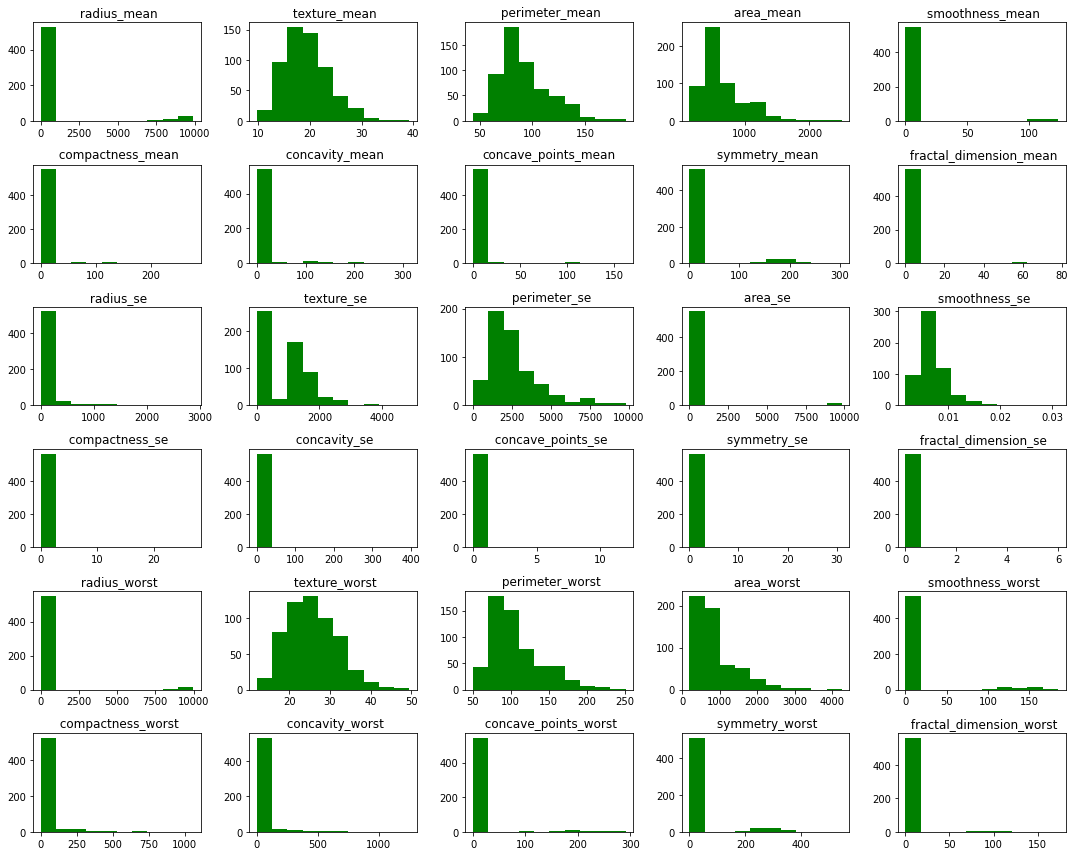

In [6]:
plt.figure(figsize=(15, 12)).patch.set_facecolor('white')
local = 1
for coluna in previsores.columns:
    plt.subplot(6, 5, local).set_title(coluna)
    plt.hist(x=previsores[coluna], color = 'green')
    local += 1
plt.tight_layout()

Com esses histogramas percebe-se um comportamento estranho na distribuição de frequências das variáveis: os valores estão muito concentrados apenas no primeiro bin.

Isso, combinado com os altos valores dos desvios padrão, é um alerta sobre a presença de outliers nos dados. Afinal se fosse um indício de alta homogeneidade, ou baixa dispersão ou variação nos dados, o desvio padrão seria pequeno e o gráfico teria mais bins. 

Para filtrar esses dados (e simplificar o modelo por consequência) será feito um corte, selecionando apenas as colunas cujos desvios padrão sejam inferiores a média.

In [7]:
colunas = desc.loc[desc['std'] < desc['mean']].index.to_list()

É lógico que, dado o teor didático deste projeto, não serão criados apenas os modelos com o filtro de dados. Também serão criados modelos que levarão em conta toda a base de dados.

Mas ainda assim há outro ponto importante a ser considerado: veja que cada variável possui um intervalo entre mínimo e máximo diferente das outras. Logo, dada a natureza dos cálculos envolvidos na criação de uma rede neural artificial, cada feature influenciará o modelo de maneira diferente e uma coluna pode influenciar mais do que a outra.

Para resolver essa questão, além do filtro, a base de dados também será pré processada a fim de fazer com que as diferentes variáveis tenham pesos plausíveis no contexto.

Serão testados dois pré-processamentos: a normalização e a padronização (ou escala).

In [8]:
normal = pd.DataFrame(minmax_scale(previsores.values, axis = 0) , columns=[previsores.columns])
escala = pd.DataFrame(scale(previsores.values, axis = 0), columns=[previsores.columns])
opcoes = [previsores, normal, escala]

Tendo as tabelas processadas podemos aplicar o filtro.

In [9]:
corte_previsores = previsores[colunas]
corte_normal = normal[colunas]
corte_escalado = escala[colunas]
cortes = [corte_previsores, corte_normal, corte_escalado]

A célula a seguir mostra boxplots que ajudarão a compreender qual o efeito do pré-processamento e do filtro sobre os dados.

Caso queira ver como são os dados sem o filtro, execute a célula posterior. (Spoiller: muitos outliers e ruído)

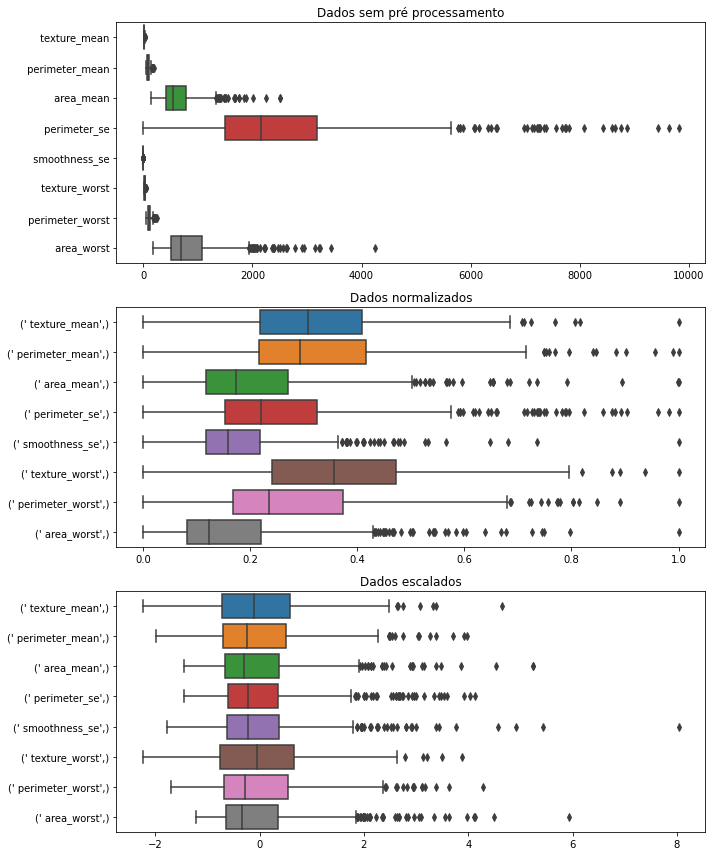

In [10]:
plt.figure(figsize=(10, 12)).patch.set_facecolor('white')
local = 0
titulos = ['Dados sem pré processamento', 'Dados normalizados', 'Dados escalados']
for item in cortes:
    plt.subplot(3, 1, local+1)
    sns.boxplot(data=item, orient = 'h').set_title(titulos[local])
    local += 1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(18, 10)).patch.set_facecolor('white')
local = 0
titulos = ['Dados sem pré processamento', 'Dados normalizados', 'Dados escalados']
for item in opcoes:
    plt.subplot(1, 3, local+1)
    sns.boxplot(data=item, orient = 'h').set_title(titulos[local])
    local += 1
plt.tight_layout()

## Criação dos elementos para o tunning

Neste bloco são criados o dicionário de parametros para serem testados, a função de criação do modelo para teste e o GridSearch

A fim de chegar a melhor combinação de parâmetros para a criação da rede neural será performado um processo de tunning dos parâmetros. Neste processo serão testadas diferentes combinações de parâmetros como otimizadores, funções de ativação, quantidade de neurônios em cada camada, número de camadas ocultas e porcentagem de dropout.

In [11]:
parametros_testados = {
    'otimizador' : ['adam', 'SGD', 'RMSprop'],
    'ativacao' : ['relu', 'elu'],
    'neuronios' : [8, 16, 32],
    'camadas': [1, 2, 3],
    'dropout': [0, 0.2, 0.25]
}

Como temos tabelas de dimensões diferentes, precisaremos incluir uma variável que leve em conta a dimensão da matriz de previsores.

In [12]:
def rede_teste (otimizador, ativacao, neuronios, camadas, dropout, dimensao, **kwargs):
    '''
    Função que retorna o modelo para teste do dicionário de parametros especificado.
    '''
    modelo = Sequential()
    modelo.add(Dense(units = neuronios, activation = ativacao, kernel_initializer = 'random_uniform',
                     input_dim = dimensao))
    modelo.add(Dropout(dropout))
    for camadas in range(camadas):
        modelo.add(Dense(units = neuronios, activation = ativacao, kernel_initializer = 'random_uniform'))
        modelo.add(Dropout(dropout))
    modelo.add(Dense(units = 1, activation = 'sigmoid'))
    modelo.compile(optimizer = otimizador, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    return modelo

Para maior comodidade e automatização, criemos duas variáveis contendo o número de colunas das tabelas com e sem filtro.

In [13]:
s_filtro = len(previsores.columns)
filtrado = len(corte_previsores.columns)
s_filtro, filtrado

(30, 8)

Chegada a hora de criar os modelos e o grid search. Serão criados dois de cada: um para as bases integras e outro para as bases cortadas. 

In [14]:
modelo = KerasClassifier(model = rede_teste, epochs = 100, batch_size = 10, verbose = False, 
                         dimensao = s_filtro, ativacao = None, otimizador = None, neuronios = None, 
                         camadas = None, dropout = None)
testes = GridSearchCV(estimator = modelo, param_grid = parametros_testados, scoring = 'accuracy', cv = 4, verbose = 1)

In [15]:
modelo_cortes = KerasClassifier(model = rede_teste, epochs = 100, batch_size = 10, verbose = False, 
                         dimensao = filtrado, ativacao = None, otimizador = None, neuronios = None, 
                         camadas = None, dropout = None)
testes_cortes = GridSearchCV(estimator = modelo_cortes, param_grid = parametros_testados,
                             scoring = 'accuracy', cv = 4, verbose = 1)

### **GridSearch fit**

Este bloco executa as duas buscas de melhores parâmetros.

Ela exige muito trabalho computacioal da máquina e executar as próximas quatro células pode levar cerca de sete horas.

Na produção deste notebook já foi executado este bloco, pode seguir à próxima subseção onde serão apresentados os resultados obtidos.

Para que não execute o bloco por acidente os código foram comentados.

In [ ]:
# contador = 0
# resultados = []
# for item in range(len(opcoes)):
#     print(f'Começando teste {contador}')
#     testes.fit(opcoes[item], classes)
#     resultados.append([contador, testes.best_params_, testes.best_score_])
#     contador += 1

In [ ]:
# resultados

In [ ]:
# contador = 0
# resultados_cortes = []
# for item in range(len(cortes)):
#     print(f'Começando teste {contador}')
#     testes_cortes.fit(cortes[item], classes)
#     resultados_cortes.append([contador, testes.best_params_, testes.best_score_])
#     contador += 1

In [ ]:
# resultados_cortes

### Resultados

Aqui são apresentados os resultados obtidos do tunning da rede neural

#### Resultados obtidos do GridSearch fit com as bases integras

Rodando o GridSearchCV para as três bases de previsores teremos os seguintes resultados:

0. Dados originais:

> Melhores parametros:

        'ativacao': 'elu',
        'camadas': 3, *além da camada de input
        'dropout': 0.2,
        'neuronios': 32,
        'otimizador': 'adam'
        
> Melhor score:

        0.9104575002462326
        
1. Dados normalizados:

> Melhores parametros:

        'ativacao': 'relu',
        'camadas': 2, *além da camada de input
        'dropout': 0,
        'neuronios': 32,
        'otimizador': 'adam'

> Melhor score:

        0.9490914015561903
        
2. Dados escalados:

> Melhores parametros:

        'ativacao': 'elu',
        'camadas': 1, *além da camada de input
        'dropout': 0.2,
        'neuronios': 16,
        'otimizador': 'adam'

> Melhor score:

        0.9525879050526938

#### Resultados obtidos do GridSearch fit com os cortes

Rodando o GridSearchCV para os cortes nas três bases de previsores teremos os seguintes resultados:

0. Dados originais:

> Melhores parametros:

        'ativacao': 'elu',
        'camadas': 1, *além da camada de input
        'dropout': 0.2,
        'neuronios': 16,
        'otimizador': 'adam'
        
> Melhor score:

        0.9525879050526938
        
1. Dados normalizados:

> Melhores parametros:

        'ativacao': 'elu',
        'camadas': 1, *além da camada de input
        'dropout': 0.2,
        'neuronios': 16,
        'otimizador': 'adam'

> Melhor score:

        0.9525879050526938
        
2. Dados escalados:

> Melhores parametros:

        'ativacao': 'elu',
        'camadas': 1, *além da camada de input
        'dropout': 0.2,
        'neuronios': 16,
        'otimizador': 'adam'

> Melhor score:

        0.9525879050526938

Vê que há um padrão entre as bases filtradas, tanto nos parâmetros quanto nos scores. Isso é bom, o modelo fica mais simples com o filtro, assim, requerendo menos operações computacionais.

Também é visível que o Adam é o melhor otimizador em todos os casos

## Validação cruzada dos melhores parametros

### Dicionários de melhores parametros, função de criação da rede neural e criação dos modelos classificadores

Criam-se dicionários com os melhores parâmetros obtidos no tunning para serem argumentos da função de criação da rede neural. Desta forma confirmaremos qual a base de dados que apresenta melhor resultado para previsoes.

In [16]:
n_preprocessado = {
    'ativacao': 'elu',
    'camadas': 3,
    'dropout': 0.2,
    'neuronios': 32
}
normalizado = {
    'ativacao': 'relu',
    'camadas': 2,
    'dropout': 0,
    'neuronios': 32
}
escalado = {
    'ativacao': 'elu',
    'camadas': 1,
    'dropout': 0.2,
    'neuronios': 16
}

Como obtivemos um padrão com o filtro de dados, basta criar apenas um dicionário com os seguintes parâmetros.

In [17]:
parametros_corte = {
    'ativacao': 'elu',
    'camadas': 1,
    'dropout': 0.2,
    'neuronios': 16
}

A célula seguinte declara a função que cria uma rede neural sequencial de acordo com os argumentos dados ou o dicionário passado. Após, são criados os modelos para cada dicionário.

In [18]:
def rede (dimensao, ativacao = 'elu', camadas = 1, dropout = 0.2, neuronios = 16, **kwargs):
    '''
    Função que retorna o modelo conforme os argumentos ou o dicionário de kwargs especificado.
        Os kwargs são:
            dimensao : int
                diz respeito ao número de variáveis previsoras na base de dados
            ativacao : \'elu\' or \'relu\', default : \'elu\'
                função de ativação das camadas ocultas
            camadas : int, default : 1
                quantas camadas ocultas, além da camada de ativação, o modelo terá
                    obs: o número total de camadas ocultas será "camadas" + 1
            dropout : float, default : 0.2
                cria camadas de dropout com a porcentagem de neuronios a serem zerados
            neuronio : int, default : 16
                determina quantas unidades haverão em cada camada
    '''
    modelo = Sequential()
    modelo.add(Dense(units = neuronios, activation = ativacao, kernel_initializer = 'random_uniform', input_dim = dimensao))
    modelo.add(Dropout(dropout))
    for camadas in range(camadas):
        modelo.add(Dense(units = neuronios, activation = ativacao, kernel_initializer = 'random_uniform'))
        modelo.add(Dropout(dropout))
    modelo.add(Dense(units = 1, activation = 'sigmoid'))
    modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    return modelo

In [19]:
modelo_n_preprocessado = KerasClassifier(model = rede(dimensao = s_filtro, **n_preprocessado), 
                                         epochs = 100, batch_size = 10, verbose = False)
modelo_normalizado = KerasClassifier(model = rede(dimensao = s_filtro, **normalizado), 
                                     epochs = 100, batch_size = 10, verbose = False)
modelo_escalado = KerasClassifier(model = rede(dimensao = s_filtro, **escalado), 
                                  epochs = 100, batch_size = 10, verbose = False)

Apesar de apenas um dicionário de parâmetros para os cortes, é necessário criar três modelos para que, ao averiguarmos a acurácia com divisão de treino e teste, os modelos não se sobreescrevam.

In [20]:
modelo_filtrado = KerasClassifier(model = rede(dimensao = filtrado, **parametros_corte), 
                                         epochs = 100, batch_size = 10, verbose = False)
modelo_fn = KerasClassifier(model = rede(dimensao = filtrado, **parametros_corte), 
                                         epochs = 100, batch_size = 10, verbose = False)
modelo_fe = KerasClassifier(model = rede(dimensao = filtrado, **parametros_corte), 
                                         epochs = 100, batch_size = 10, verbose = False)

### Validação cruzada dos modelos

Neste bloco são obtidos os resultados da validação cruzada dos modelos.

As quatro células seguintes demoram um pouco para completarem sua execução.

Caso não queira executa-las adicionei um célula de texto contendo os resultados.

In [21]:
cv_n_preprocessado = cross_val_score(estimator = modelo_n_preprocessado, 
                                     X = previsores, y = classes, cv = 10, scoring = 'accuracy')
cv_normalizado = cross_val_score(estimator = modelo_normalizado, 
                                 X = normal, y = classes, cv = 10, scoring = 'accuracy')
cv_escalado = cross_val_score(estimator = modelo_escalado, 
                              X = escala, y = classes, cv = 10, scoring = 'accuracy')

INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpf3hui8xa\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpzzwif8w7\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp9zbimzq0\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpg0ochffu\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpmok3_8bv\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmppbhftyk9\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpzzopff0e\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpnistxyia\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp18skcxx1\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpr03zsdkb\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp70lpyw6a\assets

Score para cada base de dados e modelo das bases integras.

In [22]:
cv_n_preprocessado.mean(), cv_normalizado.mean(), cv_escalado.mean()

(0.9050751879699247, 0.938408521303258, 0.956015037593985)

Output da célula acima, na sua execução em produção: 
        
        (0.9050751879699247, 0.938408521303258, 0.956015037593985)

In [23]:
cv_cnp = cross_val_score(estimator = modelo_filtrado, 
                                     X = corte_previsores, y = classes, cv = 10, scoring = 'accuracy')
cv_cn = cross_val_score(estimator = modelo_fn, 
                                 X = corte_normal, y = classes, cv = 10, scoring = 'accuracy')
cv_ce = cross_val_score(estimator = modelo_fe, 
                              X = corte_escalado, y = classes, cv = 10, scoring = 'accuracy')

INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp7nhpag9y\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpdyvmdi2p\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpa52rmdjn\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpaia__m0d\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp77jxxh7g\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmppgo9sybx\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmp7ojmha2t\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpljajex8e\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpphqord3t\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmput1knzi5\assets
INFO:tensorflow:Assets written to: C:\Users\ANDREZ~1\AppData\Local\Temp\tmpfd3kp94l\assets

Score para cada base de dados e modelo das bases filtradas.

In [24]:
cv_cnp.mean(), cv_cn.mean(), cv_ce.mean()

(0.9156641604010025, 0.9455200501253133, 0.9543233082706767)

Output da célula acima, na sua execução em produção: 
        
        (0.9156641604010025, 0.9455200501253133, 0.9543233082706767)

Percebe-se que os melhores resultados, tanto das bases filtradas quanto das não filtradas, está nos previsores ecalados, ou padronizados. O que é indício da necessidade de um pré processamento dos dados antes da criação dos modelos.

### Acurácia com divisão de treino e teste

Neste bloco testaremos a acurácia do modelo simulando uma situação de treino e teste

Separamos as bases para treino e teste da tabela de previsores, de previsores normalizados e de previsores escalados

In [25]:
p_treino, p_teste, c_treino, c_teste = train_test_split(previsores, classes, test_size = 0.25, random_state = 0)
n_treino, n_teste, _, _ = train_test_split(normal, classes, test_size = 0.25, random_state = 0)
e_treino, e_teste, _, _ = train_test_split(escala, classes, test_size = 0.25, random_state = 0)

Agora as bases com o corte

In [26]:
cp_treino, cp_teste, _, _ = train_test_split(corte_previsores, classes, test_size = 0.25, random_state = 0)
cn_treino, cn_teste, _, _ = train_test_split(corte_normal, classes, test_size = 0.25, random_state = 0)
ce_treino, ce_teste, _, _ = train_test_split(corte_escalado, classes, test_size = 0.25, random_state = 0)

Procedemos com o fit dos modelos

In [27]:
modelo_n_preprocessado.fit(p_treino, c_treino)
modelo_normalizado.fit(n_treino, c_treino)
modelo_escalado.fit(e_treino, c_treino)

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x00000253419C7CA0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=False
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

Agora os modelos filtrado, filtrado e normalizado, e filtrado e escalado

In [28]:
modelo_filtrado.fit(cp_treino, c_treino)
modelo_fn.fit(cn_treino, c_treino)
modelo_fe.fit(ce_treino, c_treino)

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x0000025341A37B80>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=False
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

Prevemos as variáveis de teste

In [29]:
p_previsores = modelo_n_preprocessado.predict(p_teste)
p_normal = modelo_normalizado.predict(n_teste)
p_escala = modelo_escalado.predict(e_teste)
previsoes_integras = [p_previsores, p_normal, p_escala]

In [30]:
p_cp = modelo_filtrado.predict(cp_teste)
p_cn = modelo_fn.predict(cn_teste)
p_ce = modelo_fe.predict(ce_teste)
previsores_filtradas = [p_cp, p_cn, p_ce]

Extraimos a pontuação de acurácia das previsões.

In [31]:
for item in previsoes_integras:
    print(accuracy_score(item, c_teste))

0.9090909090909091
0.9230769230769231
0.9440559440559441


In [32]:
for item in previsores_filtradas:
    print(accuracy_score(item, c_teste))

0.9370629370629371
0.972027972027972
0.958041958041958


Com base nos resultados vemos que, dentre as bases sem filtro, a base escalada se sai melhor;

Porém, dentre as bases filtradas, a que se sai melhor é a normalizada com impressionantes (na execução da célula em produção) 97.2% de acurácia.

## Salvando os modelos

A fim de replicar os resultados é interessante que se salvem os modelos.

Cria-se um dicionário onde cada chave corresponde a uma lista contendo o modelo e o nome que será usado para criar os arquivos.

In [33]:
modelos = {
    0 : [modelo_n_preprocessado, 'n_preprocessado'],
    1 : [modelo_normalizado, 'normalizado'],
    2 : [modelo_escalado, 'escalado'],
    3 : [modelo_filtrado, 'corte_n_preprocessado'],
    4 : [modelo_fn, 'corte_normalizado'],
    5 : [modelo_fe, 'corte_escalado']
}

In [34]:
for key in modelos:
    with open(f'modelos/{modelos[key][1]}_estrutura.json', 'w') as json_file:
        json_file.write(modelos[key][0].model_.to_json())
    modelos[key][0].model.save(f'modelos/{modelos[key][1]}_pesos.h5')

## Conclusão

Este breve e simplório projeto tinha por objetivo encontrar a melhor combinação de parâmetros e processos a fim de criar um modelo de previsão com a maior acurácia possivel para a base de dados de câncer de mama.

Chegamos a conclusão que: aplicando-se um filtro que considere apenas as variáveis mais consistentes em questão da presença de valores aberrantes; escalando os valores das variáveis previsoras; e criando um modelo de redes neurais artificiais com duas camadas, 16 neurônios em cada camada oculta, 20% nas camadas de dropout, função de ativação ELU (Exponencial Linear Unit) e usando o otimizador Adam podemos atingir 95% de acurácia com facilidade.

Ressalto a importância de se tratarem os outliers da base de dados. Contudo é necessário saber se determinados valores seriam outliers ou não. Pode ter sido aplicado o filtro e excluído variáveis cruciais para que um médico determine se o tumor é maligno ou benigno. As análises feitas nesse bloco de notas são meramente estatísticas visto que seu criador não possui expertiise ncessária para ser médico.

Portanto proponho que seja executada apenas a padronização da base de dados por meio da escala como pré processamento dos dados. Destarte não excluíremos nenhuma variável (o que vem acompanhado de um custo computacional), mas ainda teremos 95% de acurácia.